In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy
import re

# Introduction

# Wrangling the Data
The data used in this project comes from a couple of different Scrapy Spiders that I wrote for several sites, including one for the original dataset at [UK Essays](https://www.ukessays.com) website. They are called UK_pro_scraper and UK_student_scraper and can be found in this github repository. In an attempt to make my notebook more compact, I have also separated out the preprocessing and cleaning of each dataset. It is a little tedious and repetetive, but if you would like to see my steps, they are in a file called 'Text Preprocessing.ipynb', also located in this repository. The final output of that notebook is a dataframe, saved to file using pickle.

We will pick up where that file left off by loading all of our datasets into this notebook with pickle.

In [2]:
df_features = pickle.load(open('../df_features.pkl', 'rb'))
df_features.head()

,subject,joined,student,tokens,lemmas
0,nursing,Total Word Count: This report has been prepare...,student,"(Total, Word, Count, :, This, report, has, bee...",total word count : this report have be prepare...
1,nursing,"Leadership has been described as ""a relational...",student,"(Leadership, has, been, described, as, "", a, r...","leadership have be describe as "" a relational ..."
2,nursing,Depression among pregnant adolescents as well ...,student,"(Depression, among, pregnant, adolescents, as,...",depression among pregnant adolescent as well a...
3,nursing,"Davidson, E., Daly, J., Brady, R. & Higgins, P...",student,"(Davidson, ,, E., ,, Daly, ,, J., ,, Brady, ,,...","davidson , e. , daly , j. , brady , r. & higgi..."
4,nursing,Idiopathic pulmonary fibrosis (IPF) is a devas...,student,"(Idiopathic, pulmonary, fibrosis, (, IPF, ), i...",idiopathic pulmonary fibrosis ( ipf ) be a dev...


A little background, in case you decided not to look at the preprocessing steps. I'll talk about each column and describe the data in each one.
* **Subject:** Each essay was pulled from one of three subjects \[Nursing, Business, Law\] because these three subjects were the only subjects available in the professional samples for the original dataset (UK Essays). 
* **Joined:** The text in this column is the full text concatenated together. Original data from scrapy usually came in as a list of paragraph length strings, so this is what is left of the original data after preprocessing and before tokenization/lemmatization.
* **Student:** This is the target column. An essay was either written by a student (all student essays are from UK essays), or written by a professional. The two corresponding values, then, are 'student' and 'pro'.
* **Tokens:** I used the SpaCy Tokenizer to parse the text and split each word from punctuation, clean up raw values like tabs and newlines, and to tag each word with its part of speech (noun, verb, pronoun, etc.)
* **Lemmas:** A SpaCy token object has a '.lemma' attribute, which is the only reason I tokenized it. For those unfamiliar, Lemmatizaition is a way of cutting words down to their roots so that you can have less features in word vectors. For instance the words 'is', are', and 'am' will all be changed to the verb 'be'. Modifiers are also cut off (I don't know the exact name of these things), for example 'cleaning', 'cleans', and 'cleaned' will all be changed to 'clean'. Stemming is a less robust method that relies on the last couple of letters in a word instead of its part of speech to cut the word down to its root. I don't have an example for this. 

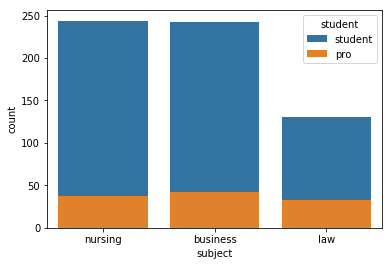

In [3]:
sns.countplot(x='subject', hue='student', data=df_features, dodge=False)
plt.show()

Unfortunately, due to some inconsistency in the way the student essays were formatted, many Law essays had to be thrown out. I think we still have enough to work with, especially since our dataset is a little bit imbalanced anyways. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True)
essays_tfidf = vectorizer.fit_transform(df_features.lemmas)
# essays_tfidf = vectorizer.fit_transform(df_features.joined)


# Getting the word list.
terms = vectorizer.get_feature_names()

You'll notice in the cell above that I tried two different ways of vectorizing the text. One with lemmatization, one without. Lemmatization reduces Doc2Vec's ability to classify the texts, but improves all of the other methods drastically.

In [5]:
vectorizer.get_params

<bound method BaseEstimator.get_params of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)>

## Unsupervised Clustering
In this section, we will reduce dimensionality using the following unsupervised methods:
- LSA
- LDA
- NNMF
- Doc2Vec

In [6]:
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def nlp_clean(data):
    
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        dlist = list(set(dlist).difference(stopword_set))
        new_data.append(dlist)
    return new_data

In [7]:
class LabeledLineSentence(object):
    
    def __init__(self, doc_list, labels_list):
        
        self.labels_list = labels_list
        self.doc_list = doc_list
        
    def __iter__(self):
        # Create an iterable of TaggedDocuments
        # Don't know why, just following the documentation
        for idx, doc in enumerate(self.doc_list):
            yield gensim.models.doc2vec.TaggedDocument(doc,
                                                       [self.labels_list[idx]])

In [8]:
data = df_features.joined.tolist()
names = df_features.subject.tolist()

In [9]:
data = nlp_clean(data)

In [10]:
from gensim.models import Doc2Vec
import gensim

# Creating our document iterable here, using the yields (technically a generator?)
it = LabeledLineSentence(data, names)

# Initialize model and build vocab
model = Doc2Vec(vector_size=50, window=8, min_count=2, workers=3, alpha=0.025, min_alpha=0.005)
model.build_vocab(it)

# Training the model
model.train(it, total_examples=len(df_features), epochs=10)

model.save('doc2vec.model')

C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [11]:
# This function reports the top n_top results for a random search
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:3]:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label='pro')
from scipy.stats import uniform as sp_uniform

X = [model.infer_vector(df_features.joined[i]) for i in range(len(df_features))]
X_train_docvec, X_test_docvec, y_train_docvec, y_test_docvec = train_test_split(X,
                                                                               df_features.student,
                                                                               test_size = 0.2)


In [13]:
param_dist = {'C':np.random.uniform(0.001, 1, 30)}
n_iter = 30
svc = SVC(class_weight='balanced')
svc_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)


svc_search.fit(X_train_docvec, y_train_docvec)          
report(svc_search.cv_results_)

Model with rank: 1
Mean validation score: 0.541 (std: 0.063)
Parameters: {'C': 0.38181361494059957}

Model with rank: 2
Mean validation score: 0.539 (std: 0.067)
Parameters: {'C': 0.510157606987688}

Model with rank: 2
Mean validation score: 0.539 (std: 0.067)
Parameters: {'C': 0.3654822507248505}

Model with rank: 2
Mean validation score: 0.539 (std: 0.067)
Parameters: {'C': 0.330516392252954}



In [14]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint

param_dist = {'n_neighbors':sp_randint(1, 10),
              'weights':['uniform', 'distance']}
n_iter = 30
knn = KNeighborsClassifier()
knn_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)


knn_search.fit(X_train_docvec, y_train_docvec)          
report(knn_search.cv_results_)

Model with rank: 1
Mean validation score: 0.548 (std: 0.076)
Parameters: {'n_neighbors': 8, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.543 (std: 0.046)
Parameters: {'n_neighbors': 6, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.543 (std: 0.046)
Parameters: {'n_neighbors': 6, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.543 (std: 0.046)
Parameters: {'n_neighbors': 6, 'weights': 'uniform'}



In [15]:
n_components = 50

In [16]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))
essays_lsa = lsa.fit_transform(essays_tfidf)

In [17]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=n_components, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/n_components,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

essays_lda = lda.fit_transform(essays_tfidf) 


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [18]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=n_components, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
essays_nmf = nmf.fit_transform(essays_tfidf) 


# Modeling
In this section, we will attempt to classify the data in as many ways as we can think of! We will also conduct a rigorous error analysis.
- Compare accuracy, f1, confusion matrix
- Try LSA,LDA, nnmf one at a time
    

In [19]:
from sklearn.model_selection import train_test_split

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(essays_lda, 
                                                                    df_features.student, 
                                                                    test_size=0.2, 
                                                                    stratify=df_features.student)

X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(essays_lsa,
                                                                    df_features.student,
                                                                    test_size=0.2,
                                                                    stratify=df_features.student)

X_train_nmf, X_test_nmf, y_train_nmf, y_test_nmf = train_test_split(essays_nmf,
                                                                    df_features.student,
                                                                    test_size=0.2,
                                                                    stratify=df_features.student)

# This is going to be a pain in the ass. I hope it actually ends up saving me time. 
# I'm going to concatenate all of these dataframes together so that I can pass them into
# a custom class, along with an estimator. The object will spit out training metrics.

# Latent Semantic Analysis
reduced_train_lsa = pd.DataFrame(data=np.append(X_train_lsa, 
                                                y_train_lsa[:, np.newaxis],
                                                1))
reduced_train_lsa['test'] = 0
reduced_test_lsa = pd.DataFrame(data=np.append(X_test_lsa, 
                                                y_test_lsa[:, np.newaxis],
                                                1))
reduced_test_lsa['test'] = 1
reduced_lsa = reduced_train_lsa.append(reduced_test_lsa, ignore_index=True)
reduced_lsa['method'] = 'lsa'
reduced_lsa.rename(columns={n_components:'target'}, inplace=True)




# Latent Dirichlet Analysis
reduced_train_lda = pd.DataFrame(data=np.append(X_train_lda, 
                                                y_train_lda[:, np.newaxis],
                                                1))
reduced_train_lda['test'] = 0
reduced_test_lda = pd.DataFrame(data=np.append(X_test_lda, 
                                                y_test_lda[:, np.newaxis],
                                                1))
reduced_test_lda['test'] = 1
reduced_lda = reduced_train_lda.append(reduced_test_lda, ignore_index=True)
reduced_lda['method'] = 'lda'
reduced_lda.rename(columns={n_components:'target'}, inplace=True)



# Non-Negative Matrix Factorization
reduced_train_nmf = pd.DataFrame(data=np.append(X_train_nmf, 
                                                y_train_nmf[:, np.newaxis],
                                                1))
reduced_train_nmf['test'] = 0
reduced_test_nmf = pd.DataFrame(data=np.append(X_test_nmf, 
                                                y_test_nmf[:, np.newaxis],
                                                1))
reduced_test_nmf['test'] = 1
reduced_nmf = reduced_train_nmf.append(reduced_test_nmf, ignore_index=True)
reduced_nmf['method'] = 'nmf'
reduced_nmf.rename(columns={n_components:'target'}, inplace=True)

# Putting it all together now:

reduced_data = reduced_lsa.copy()
reduced_data = reduced_data.append(reduced_lda, ignore_index=True)
reduced_data = reduced_data.append(reduced_nmf, ignore_index=True)
reduced_data.reset_index(inplace=True, drop=True)
# reduced_data.target = reduced_data.target.astype(np.int64) #map(lambda x: int(x))
print(reduced_data.shape[0] / 3)
reduced_data.head()

730.0


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,target,test,method
0,0.785115,-0.164523,-0.00952048,0.0735985,0.301925,-0.0926955,0.0442399,0.0164873,-0.11659,0.126724,...,-0.0157787,0.0679339,0.00549483,-0.105635,0.0130594,-0.00169317,-0.0565193,student,0,lsa
1,0.562808,-0.137363,0.0599365,0.0171604,-0.128064,0.0292084,0.0710008,-0.0221945,-0.389115,0.0910589,...,0.237277,-0.106184,0.00250128,-0.0567713,0.0697015,-0.258017,-0.0763964,pro,0,lsa
2,0.721463,0.350559,-0.134512,-0.0923412,0.230676,0.0579614,0.154315,-0.0693565,-0.042255,-0.0510895,...,0.0517471,-0.105865,-0.0803959,0.207157,0.0116383,-0.0894696,-0.0662505,student,0,lsa
3,0.54096,0.359591,-0.12489,0.118133,0.214989,-0.31223,0.305237,0.00634222,0.0715107,-0.163399,...,0.0114089,0.0503208,0.232363,0.110342,0.0113904,0.030096,-0.0213729,student,0,lsa
4,0.379796,0.404427,-0.148599,0.270323,-0.283336,-0.0664504,-0.00375481,0.23951,0.0887958,-0.0911244,...,-0.116746,0.301664,-0.0250439,-0.196527,0.198361,0.0613054,-0.0377885,student,0,lsa


f1 = 1 / ((1/recall) + (1/precision))

In [57]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# import itertools

# class TryAllThree():
#     # This class must be used with a RandomizedSearchCV object as the estimator.
#     # It also requires a data frame with columns:
#     # [0, 1, 2, ..., n_examples, 'target', 'test', 'method']
#     def __init__(self, estimator, data):
#         self.estimator = estimator
#         self.data = data
#         self.methods = self.data.method.unique()
#         self.results = []
#         self.results_confusion = []
        
#     # This method trains (fits) the classifier and then runs a
#     def fit_score(self):
#         test = 0
#         for method in self.methods:
#             self.x = self.data[(self.data['test'] == test) & 
#                           (self.data['method'] == method)].iloc[:, :50]
#             self.y = self.data[(self.data['test'] == test) & 
#                           (self.data['method'] == method)].loc[:, 'target']
#             self.estimator.fit(self.x, self.y)
#             self.report(self.estimator.cv_results_, method)
#             self.confusion(self.estimator, self.x, self.y)
            
#             # Predict test scores using best estimator. No peaking until you're done tuning!
#             self.X_test = self.data[(self.data['test'] == 1) & 
#                           (self.data['method'] == method)].iloc[:, :50]
#             self.y_test = self.data[(self.data['test'] == 1) & 
#                           (self.data['method'] == method)].loc[:, 'target']
#             self.results.append((method, f1_scorer(self.estimator.best_estimator_, self.X_test, self.y_test)))
#             self.results_confusion.append(confusion_matrix(self.y_test,
#                                                            self.estimator.best_estimator_.predict(self.X_test)))
#     # This method scores on the test data
#     def score(self):
#         for i, result in enumerate(self.results):
#             print('Test score for {0} method: {1}'.format(result[0], result[1]))
#             self.plot_confusion_matrix(self.results_confusion[i], ['pro', 'student'])
            
#     def report(self, results, method, n_top=5):
#         count = 0
#         for i in range(1, n_top + 1):
#             candidates = np.flatnonzero(results['rank_test_score'] == i)
#             for candidate in candidates[:1]:
#                 if count == 1:
#                     break
#                 print("Method: {0} with rank: {1}".format(method.upper(), i))
#                 print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                       results['mean_test_score'][candidate],
#                       results['std_test_score'][candidate]))
#                 print("Fold-scores: [{0:.3f}, {1:.3f}, {2:.3f}".format(
#                       results['split0_test_score'][candidate],
#                     results['split1_test_score'][candidate],
#                     results['split2_test_score'][candidate]))
#                 print("Parameters: {0}".format(results['params'][candidate]))
#                 print("")
#                 count += 1
        
#     def confusion(self, estimator, x, y):
#         np.set_printoptions(precision=3)
#         y_pred = estimator.best_estimator_.predict(x)
#         print('Best accuracy acheived: ', accuracy_score(y, y_pred))
#         print('* * * * * * * * * * * * * * * * * * * *')
#         cnf_matrix = confusion_matrix(y, y_pred, labels=['pro', 'student'])
#         classes = ['pro', 'student']
#         plt.figure()
#         self.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False)
# #         plt.show()
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
        
        
#     def plot_confusion_matrix(self, cm, classes,
#                               normalize=False,
#                               title='Confusion matrix',
#                               cmap=plt.cm.Blues):
#         """
#         This function prints and plots the confusion matrix.
#         Normalization can be applied by setting `normalize=True`.
#         """
#         if normalize:
#             cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#             print("Normalized confusion matrix")
#         else:
#             print('Confusion matrix, without normalization')

#         print(cm)

#         plt.imshow(cm, interpolation='nearest', cmap=cmap)
#         plt.title(title)
#         plt.colorbar()
#         tick_marks = np.arange(len(classes))
#         plt.xticks(tick_marks, classes, rotation=45)
#         plt.yticks(tick_marks, classes)

#         fmt = '.2f' if normalize else 'd'
#         thresh = cm.max() / 2.
#         for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, format(cm[i, j], fmt),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")

#         plt.tight_layout()
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()

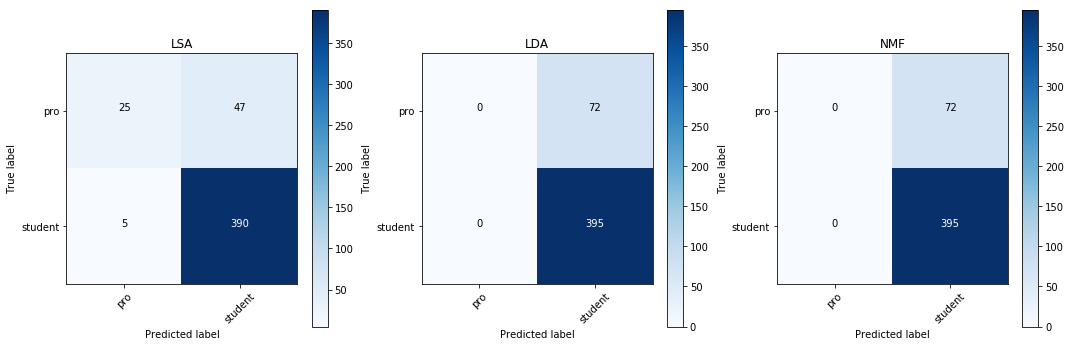

            Training Score: 0.631                         Training Score: 0.0                           Training Score: 0.0               
            Validation Score: 0.622                       Validation Score: 0.0                         Validation Score: 0.0             


In [432]:
import warnings
from sklearn.metrics import confusion_matrix
import itertools

class RandomSearch(object):
    def __init__(self, estimator, params, cnf_matrix=True, **kwargs):
        self.estimator = estimator
        self.params = params
        self.kwargs = kwargs
        self.x_data = {'train':[], 'val':[], 'test':[]}
        self.y_data = {'train':[], 'val':[], 'test':[]}
        self.param_dict = {}
        
        
    def fit(self, data):
        self.methods = data.method.unique().tolist()
        self.data = data
        # First, unpack our dataset into all the parts we will need
        for method in self.methods:
            x_train, x_val, y_train, y_val = train_test_split(data[(data['test']==0) & (data['method'] == method)].iloc[:, :50], # Make this dynamic
                                                              data[(data['test']==0) & (data['method'] == method)]['target'],
                                                              test_size=0.2,
                                                              stratify=data[(data['test']==0) & (data['method'] == method)]['target'])
            # Store each chunk into appropriate variable as a list
            self.x_data['train'].append(x_train)
            self.x_data['val'].append(x_val)
            self.x_data['test'].append(data[(data['test']==1) & (data['method'] == method)].iloc[:, :50])
            self.y_data['train'].append(y_train)
            self.y_data['val'].append(y_val)
            self.y_data['test'].append(data[(data['test']==1) & (data['method'] == method)]['target'])
        
        # This will be where we store all of our results
        self.results = {'n_methods': len(self.methods)}
        methods_ = {}
        for method in self.methods:
            methods_[method] = {'train':[], 'val':[], 'test':[]}
        self.results['scores_'] = methods_.copy()
        self.results['saved_params'] = []
        # Now we can unpack our parameter distributions
        self.n_iter = self.kwargs.pop('n_iter')
        for param in self.params:
            self.param_dict[param] = self.unpack_dists(self.params[param], self.n_iter)
        
        for i, method in enumerate(self.methods):
            # Initialize a temp container for each iterations random parameters
            self.temp_params = {}
            
            for j in range(self.n_iter):
                
                # Take out one from each of the param distributions passed
                for param in self.param_dict:
                    self.temp_params[param] = self.param_dict[param][j]
                
                # Yay for keyword arguments. The double stars unpack the temp_dict as arguments
                self.estimator.set_params(**self.temp_params)
                
                # Train our classifier, and save all of its parameters to the results
                self.estimator.fit(self.x_data['train'][i], self.y_data['train'][i])
                self.results['saved_params'].append(self.estimator.get_params())
                
                # Generate score data for train, val, and test sets
                for option in ['train', 'test', 'val']:
                    self.generate_score_data(self.estimator, i, option)
                
                
    def unpack_dists(self, declaration, n_iter):
        if declaration[0] == 'uniform':
            return np.random.uniform(declaration[1][0], declaration[1][1], n_iter)
        else:
            return np.random.randint(declaration[1][0], declaration[1][1], n_iter)
            
            
    def generate_score_data(self, estimator, i, option, refit=False):
        # Initialize x/y data from self
        x = self.x_data[option][i]
        y = self.y_data[option][i]
        
        # Use custom scoring function if specified, and catch annoying warnings.
        if self.kwargs['scoring']:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scoring_function = self.kwargs['scoring']
                score_ = scoring_function(estimator, x, y)
        else:
            # Or use the default scoring method if none specified
            score_ = estimator.score(x, y)
        self.results['scores_'][self.methods[i]][option].append(score_)

        
    def print_score_report(self, option=None):
        self.best_index = []
        methods_ = {}
        for method in self.methods:
            methods_[method] = {'train':None, 'val':None, 'test':None}
        best_scores = methods_.copy()
        self.results['best_scores'] = best_scores.copy()     
        
       
        
        

        for i, method in enumerate(self.methods):
            self.best_index.append(np.argmax(self.results['scores_'][method]['test']))
            for option in ['train', 'val']:
                self.results['best_scores'][method][option] = self.results['scores_'][method][option][self.best_index[i]]
        
        # Let's start with the confusion matrix
        cnf_matrix = []
        for i in range(self.results['n_methods']):
            x, y = self.x_data['train'][i], self.y_data['train'][i]
            self.estimator.fit(x, y)
            cnf_matrix.append(confusion_matrix(y, self.estimator.predict(x)))
            
        self.plot_confusion_matrix(cnf_matrix, classes=['pro', 'student'])
        
        print_row = []
        print_row.extend([[self.results['best_scores'][method][option] 
                          for method in self.methods] 
                          for option in ['train', 'val']])
        formatting_string = ['            Training Score: ', '            Validation Score: ']
        for i, row in enumerate(print_row):
            row = [formatting_string[i]+str(score)[:5] for score in row]
            print(''.join(word.ljust(46) for word in row))

            
    def plot_confusion_matrix(self, cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.figure(figsize=(15,5))
        for k in range(1, self.results['n_methods']+1):
            plt.subplot(1, 3, k)
            plt.imshow(cm[k-1], interpolation='nearest', cmap=cmap)
            plt.title('{}'.format(self.methods[k-1].upper()))
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = '.2f' if normalize else 'd'
            thresh = cm[k-1].max() / 2.
            for i, j in itertools.product(range(cm[k-1].shape[0]), range(cm[k-1].shape[1])):
                plt.text(j, i, format(cm[k-1][i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[k-1][i, j] > thresh else "black")

            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
        plt.show()
        
param_dist = {'C':['uniform', (0.001, 2.0)]}
svc = SVC(class_weight='balanced')
test = RandomSearch(svc, param_dist, n_iter=2,
                    scoring=f1_scorer)
test.fit(reduced_data)

test.print_score_report()

In [397]:
svc.get_params()

{'C': 0.7631078103902009,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [58]:
# A few things we might need in the future
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import recall_score
recall_scorer = make_scorer(recall_score, pos_label='pro')

### Naive Bayes on tfidf vector

In [59]:
from sklearn.naive_bayes import MultinomialNB

param_dist = {'alpha':np.random.uniform(0.001, 10, 30)}
n_iter = 30
mnb = MultinomialNB()
mnb_search = RandomizedSearchCV(mnb, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

mnb_search.fit(essays_tfidf, df_features.student)
report(mnb_search.cv_results_)

Model with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 2.4440482183612025}

Model with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 6.74023425664564}

Model with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 9.874024370267849}



## LinearSVC

Method: LSA with rank: 1
Mean validation score: 0.558 (std: 0.069)
Fold-scores: [0.475, 0.558, 0.643
Parameters: {'C': 4.710781569781015}

Best accuracy acheived:  0.8835616438356164
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 83   7]
 [ 61 433]]


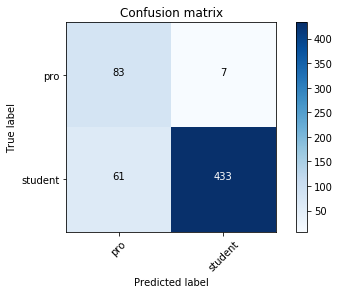

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.305 (std: 0.055)
Fold-scores: [0.267, 0.267, 0.383
Parameters: {'C': 3.4841605684136123}

Best accuracy acheived:  0.1541095890410959
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [494   0]]


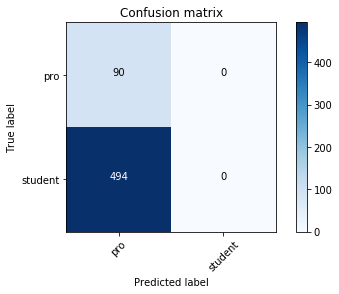

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.324 (std: 0.082)
Fold-scores: [0.267, 0.267, 0.441
Parameters: {'C': 3.4841605684136123}

Best accuracy acheived:  0.1541095890410959
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [494   0]]


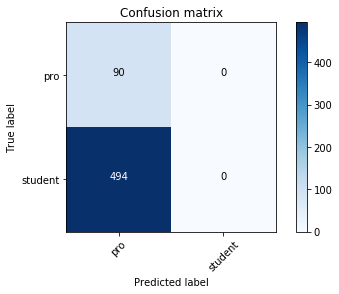

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [60]:
from sklearn.svm import LinearSVC

param_dist = {'C':np.random.uniform(0.001, 5, 50)}
n_iter = 50
lin_svc = SVC(class_weight='balanced')
lin_svc_search = RandomizedSearchCV(lin_svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

lin_svc_clf = TryAllThree(lin_svc_search, reduced_data)
lin_svc_clf.fit_score()

Method: LSA with rank: 1
Mean validation score: 0.125 (std: 0.000)
Fold-scores: [0.125, 0.125, 0.125
Parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.3596750423350481, 'max_samples': 0.9187358218754924, 'n_estimators': 7}

Best accuracy acheived:  0.9965753424657534
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 88   2]
 [  0 494]]


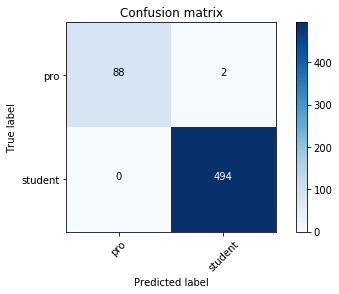

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: LDA with rank: 1
Mean validation score: 0.480 (std: 0.051)
Fold-scores: [0.549, 0.465, 0.426
Parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.9578260651774753, 'max_samples': 0.47582929754669445, 'n_estimators': 9}

Best accuracy acheived:  0.8921232876712328
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 39  51]
 [ 12 482]]


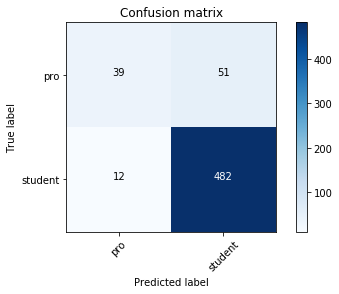

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.343 (std: 0.054)
Fold-scores: [0.400, 0.359, 0.270
Parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.9833256858687374, 'max_samples': 0.8369693226405992, 'n_estimators': 13}

Best accuracy acheived:  0.9982876712328768
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 89   1]
 [  0 494]]


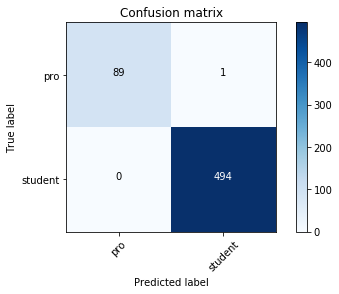

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [130]:
from sklearn.ensemble import BaggingClassifier

param_dist = {'n_estimators':sp_randint(5, 25), 'max_samples':np.random.uniform(0.3, 1.0, 50), 
              'max_features':np.random.uniform(0.3, 1.0, 50), 'bootstrap':[True, False], 
              'bootstrap_features':[True, False]}
n_iter = 250
bagging = BaggingClassifier(rand_for)
bag_search = RandomizedSearchCV(bagging, param_distributions=param_dist, 
                                n_iter=n_iter, scoring=f1_scorer,
                                n_jobs=-1)

bag_clf = TryAllThree(bag_search, reduced_data)
bag_clf.fit_score()

Method: LSA with rank: 1
Mean validation score: 0.132 (std: 0.145)
Fold-scores: [0.062, 0.333, 0.000
Parameters: {}

Best accuracy acheived:  1.0
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [  0 494]]


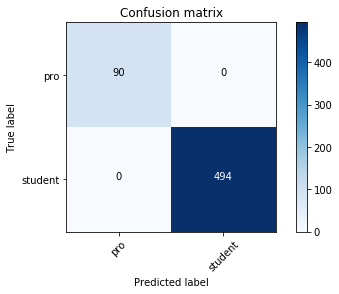

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.298 (std: 0.056)
Fold-scores: [0.364, 0.226, 0.303
Parameters: {}

Best accuracy acheived:  1.0
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [  0 494]]


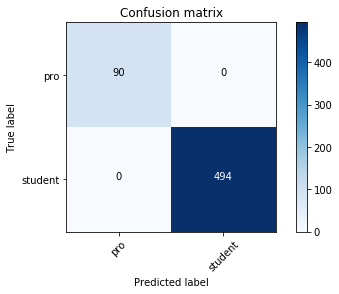

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.250 (std: 0.074)
Fold-scores: [0.229, 0.350, 0.171
Parameters: {}

Best accuracy acheived:  1.0
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [  0 494]]


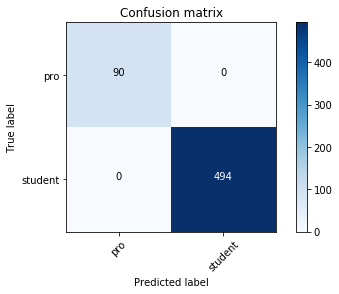

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [137]:
from sklearn.ensemble import AdaBoostClassifier

param_dist = {}
n_iter = 1
boosted_bag = bag_search.best_estimator_
ada_lsvc = AdaBoostClassifier(boosted_bag, algorithm='SAMME.R')
ada_lsvc_search = RandomizedSearchCV(ada_lsvc, param_distributions=param_dist, 
                                     n_iter=n_iter, scoring=f1_scorer,
                                     n_jobs=-1)

ada_lsvc_clf = TryAllThree(ada_lsvc_search, reduced_data)
ada_lsvc_clf.fit_score()

In [129]:
from sklearn.ensemble import AdaBoostClassifier

param_dist = {'n_estimators':sp_randint(5, 25), 'max_samples':np.random.uniform(0.3, 1.0, 50), 
              'max_features':np.random.uniform(0.3, 1.0, 50), 'bootstrap':[True, False], 
              'bootstrap_features':[True, False]}
n_iter = 250
boosted_bag = bagging.best_esticmator_
ada_lsvc = AdaBoostClassifier(bagging, algorithm='SAMME.R')
ada_lsvc_search = RandomizedSearchCV(ada_lsvc, param_distributions=param_dist, 
                                     n_iter=n_iter, scoring=f1_scorer,
                                     n_jobs=-1)

ada_lsvc_clf = TryAllThree(ada_lsvc_search, reduced_data)
ada_lsvc_clf.fit_score()

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001C949C28930, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\bretw\AppData\Local\Continuum\anaconda3...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\b...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001C949C28930, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\bretw\AppData\Local\Continuum\anaconda3...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\b...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 13, 22, 24, 1, 435685, tzinfo=tzutc()), 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'session': 'f0b193e479b9d5a258dce9ae6f12f46b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f0b193e479b9d5a258dce9ae6f12f46b']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 13, 22, 24, 1, 435685, tzinfo=tzutc()), 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'session': 'f0b193e479b9d5a258dce9ae6f12f46b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f0b193e479b9d5a258dce9ae6f12f46b'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 13, 22, 24, 1, 435685, tzinfo=tzutc()), 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'session': 'f0b193e479b9d5a258dce9ae6f12f46b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5983208b0045f9be64ad807ba38292ac', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.ensemble import AdaBoostClassifier\n...vc_search, reduced_data)\nada_lsvc_clf.fit_score()', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-129-12c15e6721cf>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c96e754898, executio..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001C969CE9D20, file "<ipython-input-129-12c15e6721cf>", line 14>
        result = <ExecutionResult object at 1c96e754898, executio..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001C969CE9D20, file "<ipython-input-129-12c15e6721cf>", line 14>, result=<ExecutionResult object at 1c96e754898, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001C969CE9D20, file "<ipython-input-129-12c15e6721cf>", line 14>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Doc2Vec': <class 'gensim.models.doc2vec.Doc2Vec'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...aborn as sns\nimport pickle\nimport spacy\nimport re', "df_features = pickle.load(open('../df_features.pkl', 'rb'))\ndf_features.head()", "sns.countplot(x='subject', hue='student', data=df_features, dodge=False)\nplt.show()", 'from sklearn.feature_extraction.text import Tfid...word list.\nterms = vectorizer.get_feature_names()', 'vectorizer.get_params', 'from nltk import RegexpTokenizer\nfrom nltk.corpu...       new_data.append(dlist)\n    return new_data', 'class LabeledLineSentence(object):\n    \n    def ...                         [self.labels_list[idx]])', 'data = df_features.joined.tolist()\nnames = df_features.subject.tolist()', 'data = nlp_clean(data)', "from gensim.models import Doc2Vec\nimport gensim\n...eatures), epochs=10)\n\nmodel.save('doc2vec.model')", '# This function reports the top n_top results fo...ults[\'params\'][candidate]))\n            print("")', 'from sklearn.svm import SVC\nfrom sklearn.model_s...                                 test_size = 0.2)', "param_dist = {'C':np.random.uniform(0.001, 1, 30..._docvec)          \nreport(svc_search.cv_results_)", 'from sklearn.neighbors import KNeighborsClassifi..._docvec)          \nreport(knn_search.cv_results_)', 'n_components = 50', '# LSA\n\nfrom sklearn.decomposition import Truncat...se))\nessays_lsa = lsa.fit_transform(essays_tfidf)', '# LDA\nfrom sklearn.decomposition import LatentDi... )\n\nessays_lda = lda.fit_transform(essays_tfidf) ', '# NNMF\n\nfrom sklearn.decomposition import NMF\n\nn...  )\nessays_nmf = nmf.fit_transform(essays_tfidf) ', 'from sklearn.model_selection import train_test_s...nt(reduced_data.shape[0] / 3)\nreduced_data.head()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LDA': <class 'sklearn.decomposition.online_lda.LatentDirichletAllocation'>, 'LabeledLineSentence': <class '__main__.LabeledLineSentence'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'Doc2Vec': <class 'gensim.models.doc2vec.Doc2Vec'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...aborn as sns\nimport pickle\nimport spacy\nimport re', "df_features = pickle.load(open('../df_features.pkl', 'rb'))\ndf_features.head()", "sns.countplot(x='subject', hue='student', data=df_features, dodge=False)\nplt.show()", 'from sklearn.feature_extraction.text import Tfid...word list.\nterms = vectorizer.get_feature_names()', 'vectorizer.get_params', 'from nltk import RegexpTokenizer\nfrom nltk.corpu...       new_data.append(dlist)\n    return new_data', 'class LabeledLineSentence(object):\n    \n    def ...                         [self.labels_list[idx]])', 'data = df_features.joined.tolist()\nnames = df_features.subject.tolist()', 'data = nlp_clean(data)', "from gensim.models import Doc2Vec\nimport gensim\n...eatures), epochs=10)\n\nmodel.save('doc2vec.model')", '# This function reports the top n_top results fo...ults[\'params\'][candidate]))\n            print("")', 'from sklearn.svm import SVC\nfrom sklearn.model_s...                                 test_size = 0.2)', "param_dist = {'C':np.random.uniform(0.001, 1, 30..._docvec)          \nreport(svc_search.cv_results_)", 'from sklearn.neighbors import KNeighborsClassifi..._docvec)          \nreport(knn_search.cv_results_)', 'n_components = 50', '# LSA\n\nfrom sklearn.decomposition import Truncat...se))\nessays_lsa = lsa.fit_transform(essays_tfidf)', '# LDA\nfrom sklearn.decomposition import LatentDi... )\n\nessays_lda = lda.fit_transform(essays_tfidf) ', '# NNMF\n\nfrom sklearn.decomposition import NMF\n\nn...  )\nessays_nmf = nmf.fit_transform(essays_tfidf) ', 'from sklearn.model_selection import train_test_s...nt(reduced_data.shape[0] / 3)\nreduced_data.head()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LDA': <class 'sklearn.decomposition.online_lda.LatentDirichletAllocation'>, 'LabeledLineSentence': <class '__main__.LabeledLineSentence'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\bretw\Desktop\Bootcamp\Assignments\Unit 7 - Final Capstone\Final-Capstone\<ipython-input-129-12c15e6721cf> in <module>()
      9 ada_lsvc_search = RandomizedSearchCV(ada_lsvc, param_distributions=param_dist, 
     10                                      n_iter=n_iter, scoring=f1_scorer,
     11                                      n_jobs=-1)
     12 
     13 ada_lsvc_clf = TryAllThree(ada_lsvc_search, reduced_data)
---> 14 ada_lsvc_clf.fit_score()

...........................................................................
C:\Users\bretw\Desktop\Bootcamp\Assignments\Unit 7 - Final Capstone\Final-Capstone\<ipython-input-57-640ac4cbb059> in fit_score(self=<__main__.TryAllThree object>)
     19         for method in self.methods:
     20             self.x = self.data[(self.data['test'] == test) & 
     21                           (self.data['method'] == method)].iloc[:, :50]
     22             self.y = self.data[(self.data['test'] == test) & 
     23                           (self.data['method'] == method)].loc[:, 'target']
---> 24             self.estimator.fit(self.x, self.y)
     25             self.report(self.estimator.cv_results_, method)
     26             self.confusion(self.estimator, self.x, self.y)
     27             
     28             # Predict test scores using best estimator. No peaking until you're done tuning!

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=None, error_score='raise',...=make_scorer(f1_score, pos_label=pro), verbose=0), X=           0            1           2           ... 0.143267     0.079281  

[584 rows x 50 columns], y=0      student
1          pro
2      student
3  ... student
Name: target, Length: 584, dtype: object, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =            0            1           2           ... 0.143267     0.079281  

[584 rows x 50 columns]
        y = 0      student
1          pro
2      student
3  ... student
Name: target, Length: 584, dtype: object
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun May 13 15:24:02 2018
PID: 4036Python 3.6.4: C:\Users\bretw\AppData\Local\Continuum\anaconda3\python.exe
...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (AdaBoostClassifier(algorithm='SAMME.R',
        ...ing_rate=1.0, n_estimators=50, random_state=None),            0            1           2           ... 0.143267     0.079281  

[584 rows x 50 columns], 0      student
1          pro
2      student
3  ... student
Name: target, Length: 584, dtype: object, {'score': make_scorer(f1_score, pos_label=pro)}, array([189, 190, 191, 192, 194, 197, 198, 199, 2...74, 575, 576, 577, 578, 579, 580, 581, 582, 583]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...85, 186, 187, 188, 193, 195, 196, 205, 212, 230]), 0, {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5528385445804997, 'max_samples': 0.7240855500499848, 'n_estimators': 12}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (AdaBoostClassifier(algorithm='SAMME.R',
        ...ing_rate=1.0, n_estimators=50, random_state=None),            0            1           2           ... 0.143267     0.079281  

[584 rows x 50 columns], 0      student
1          pro
2      student
3  ... student
Name: target, Length: 584, dtype: object, {'score': make_scorer(f1_score, pos_label=pro)}, array([189, 190, 191, 192, 194, 197, 198, 199, 2...74, 575, 576, 577, 578, 579, 580, 581, 582, 583]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...85, 186, 187, 188, 193, 195, 196, 205, 212, 230]), 0, {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5528385445804997, 'max_samples': 0.7240855500499848, 'n_estimators': 12})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=AdaBoostClassifier(algorithm='SAMME.R',
        ...ing_rate=1.0, n_estimators=50, random_state=None), X=           0            1           2           ... 0.143267     0.079281  

[584 rows x 50 columns], y=0      student
1          pro
2      student
3  ... student
Name: target, Length: 584, dtype: object, scorer={'score': make_scorer(f1_score, pos_label=pro)}, train=array([189, 190, 191, 192, 194, 197, 198, 199, 2...74, 575, 576, 577, 578, 579, 580, 581, 582, 583]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...85, 186, 187, 188, 193, 195, 196, 205, 212, 230]), verbose=0, parameters={'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5528385445804997, 'max_samples': 0.7240855500499848, 'n_estimators': 12}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of AdaBoo...ng_rate=1.0, n_estimators=50, random_state=None)>
        parameters = {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5528385445804997, 'max_samples': 0.7240855500499848, 'n_estimators': 12}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py in set_params(self=AdaBoostClassifier(algorithm='SAMME.R',
        ...ing_rate=1.0, n_estimators=50, random_state=None), **params={'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5528385445804997, 'max_samples': 0.7240855500499848, 'n_estimators': 12})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'bootstrap'
        self = AdaBoostClassifier(algorithm='SAMME.R',
        ...ing_rate=1.0, n_estimators=50, random_state=None)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter bootstrap for estimator AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
    ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

Test score for lsa method: 0.16666666666666669
Confusion matrix, without normalization
[[  2  20]
 [  0 124]]


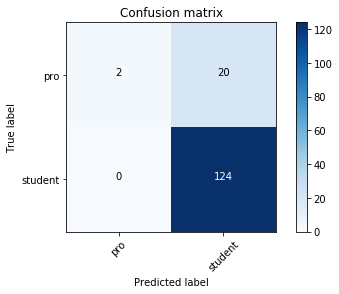

Test score for lda method: 0.5581395348837208
Confusion matrix, without normalization
[[ 12  10]
 [  9 115]]


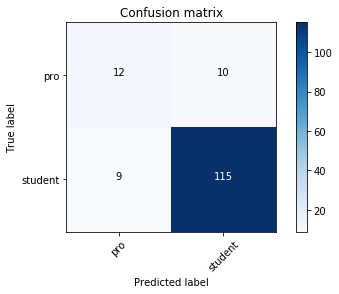

Test score for nmf method: 0.20689655172413793
Confusion matrix, without normalization
[[  3  19]
 [  4 120]]


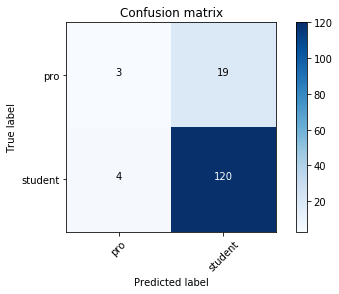

In [127]:
bag_clf.score()

### SVC

Method: LSA with rank: 1
Mean validation score: 0.478 (std: 0.068)
Fold-scores: [0.433, 0.426, 0.575
Parameters: {'C': 0.9624556344203188}

Best accuracy acheived:  0.8732876712328768
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 61  29]
 [ 45 449]]


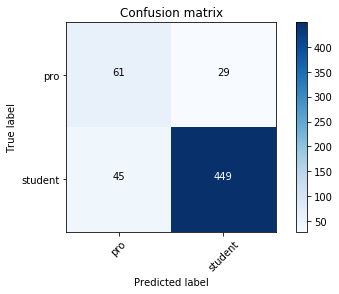

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.305 (std: 0.055)
Fold-scores: [0.267, 0.267, 0.383
Parameters: {'C': 0.7147972230720175}

Best accuracy acheived:  0.8458904109589042
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[  0  90]
 [  0 494]]


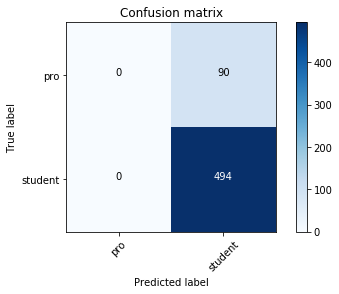

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: NMF with rank: 1
Mean validation score: 0.324 (std: 0.082)
Fold-scores: [0.267, 0.267, 0.441
Parameters: {'C': 0.7147972230720175}

Best accuracy acheived:  0.8458904109589042
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[  0  90]
 [  0 494]]


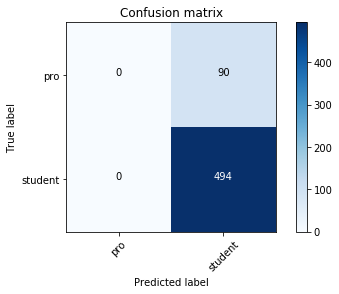

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
from sklearn.svm import SVC

param_dist = {'C':np.random.uniform(0.001, 1, 30)}
n_iter = 30
svc = SVC(class_weight='balanced')
svc_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

svc_clf = TryAllThree(svc_search, reduced_data)
svc_clf.fit_score()

### K-Nearest Neighbors

Method: LSA with rank: 1
Mean validation score: 0.511 (std: 0.038)
Fold-scores: [0.459, 0.525, 0.548
Parameters: {'n_neighbors': 2, 'weights': 'uniform'}

Best accuracy acheived:  0.9623287671232876
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 90   0]
 [ 22 472]]


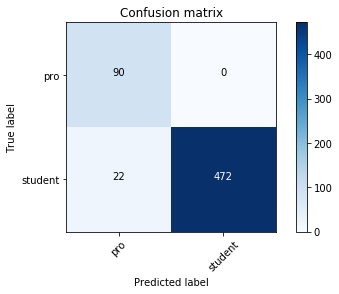

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.443 (std: 0.069)
Fold-scores: [0.520, 0.455, 0.353
Parameters: {'n_neighbors': 8, 'weights': 'uniform'}

Best accuracy acheived:  0.8715753424657534
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 35  55]
 [ 20 474]]


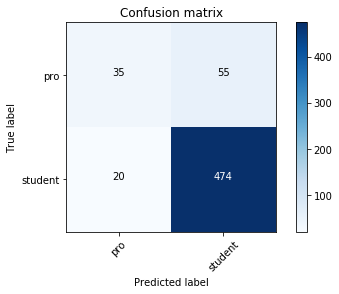

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.369 (std: 0.049)
Fold-scores: [0.316, 0.357, 0.433
Parameters: {'n_neighbors': 6, 'weights': 'uniform'}

Best accuracy acheived:  0.8835616438356164
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 46  44]
 [ 24 470]]


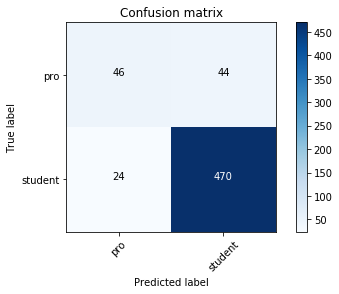

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [62]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint

param_dist = {'n_neighbors':sp_randint(1, 15),
              'weights':['uniform', 'distance']}
n_iter = 30
knn = KNeighborsClassifier()
knn_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

knn_clf = TryAllThree(knn_search, reduced_data)
knn_clf.fit_score()

### Random Forest

Method: LSA with rank: 1
Mean validation score: 0.339 (std: 0.079)
Fold-scores: [0.229, 0.409, 0.381
Parameters: {'n_estimators': 8}

Best accuracy acheived:  0.9931506849315068
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 87   3]
 [  1 493]]


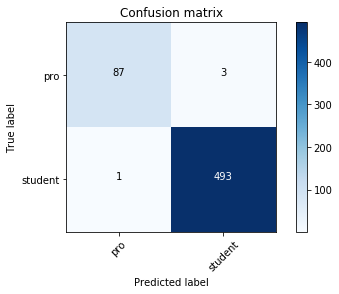

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.362 (std: 0.012)
Fold-scores: [0.373, 0.345, 0.369
Parameters: {'n_estimators': 8}

Best accuracy acheived:  0.9657534246575342
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 84   6]
 [ 14 480]]


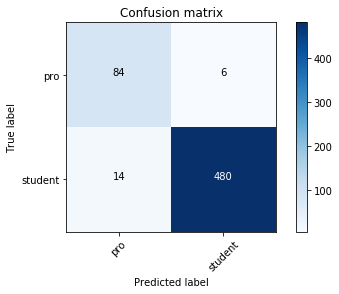

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.423 (std: 0.085)
Fold-scores: [0.500, 0.465, 0.304
Parameters: {'n_estimators': 14}

Best accuracy acheived:  0.9948630136986302
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 87   3]
 [  0 494]]


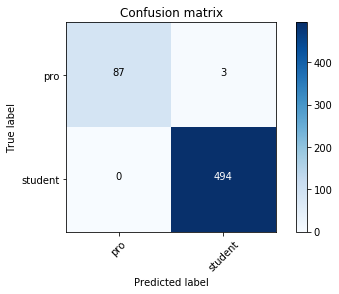

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [63]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

param_dist = {'n_estimators':sp_randint(5, 20)}
n_iter = 30
rand_for = RandomForestClassifier(class_weight='balanced')
rand_for_search = RandomizedSearchCV(rand_for, param_distributions=param_dist,
                                     n_iter=n_iter, scoring=f1_scorer,
                                     n_jobs=-1)

rand_for_clf = TryAllThree(rand_for_search, reduced_data)
rand_for_clf.fit_score()

Dammit. Time to bust out the big guns.

Method: LSA with rank: 1
Mean validation score: 0.377 (std: 0.122)
Fold-scores: [0.250, 0.341, 0.542
Parameters: {'n_estimators': 8}

Best accuracy acheived:  0.9897260273972602
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 85   5]
 [  1 493]]


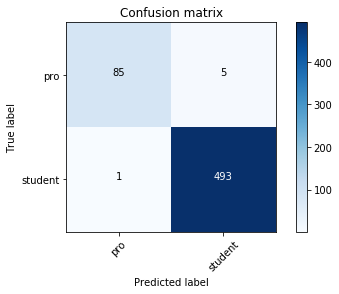

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.346 (std: 0.029)
Fold-scores: [0.387, 0.333, 0.319
Parameters: {'n_estimators': 6}

Best accuracy acheived:  0.9743150684931506
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 82   8]
 [  7 487]]


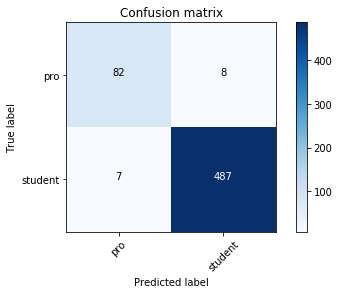

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.413 (std: 0.019)
Fold-scores: [0.400, 0.400, 0.440
Parameters: {'n_estimators': 10}

Best accuracy acheived:  0.9948630136986302
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 88   2]
 [  1 493]]


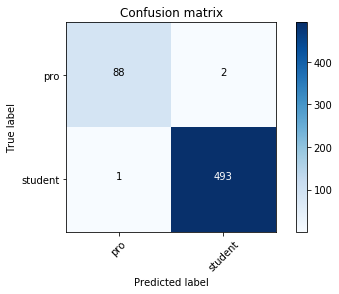

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [64]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500, 50, 5))
param_dist = {}
mlp_search = RandomizedSearchCV(mlp, param_distributions=param_dist,
                                n_iter=1, scoring=f1_scorer,
                                n_jobs=-1, )
mlp_clf = TryAllThree(rand_for_search, reduced_data)
mlp_clf.fit_score()

# Failure Analysis

Test score for lsa method: 0.3333333333333333
Confusion matrix, without normalization
[[  5  17]
 [  3 121]]


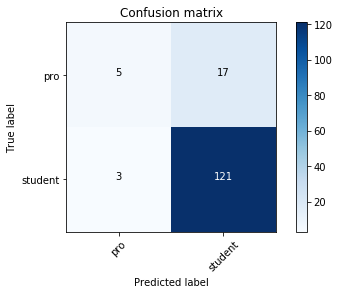

Test score for lda method: 0.3902439024390244
Confusion matrix, without normalization
[[  8  14]
 [ 11 113]]


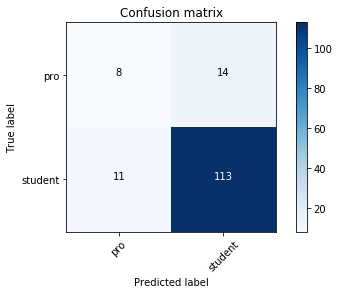

Test score for nmf method: 0.2105263157894737
Confusion matrix, without normalization
[[  4  18]
 [ 12 112]]


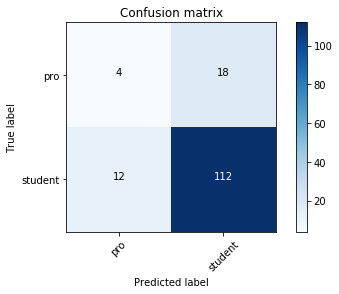

In [65]:
mlp_clf.score()

Test score for lsa method: 0.5666666666666667
Confusion matrix, without normalization
[[ 17   5]
 [ 21 103]]


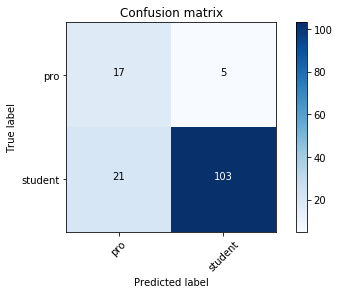

Test score for lda method: 0.2619047619047619
Confusion matrix, without normalization
[[ 22   0]
 [124   0]]


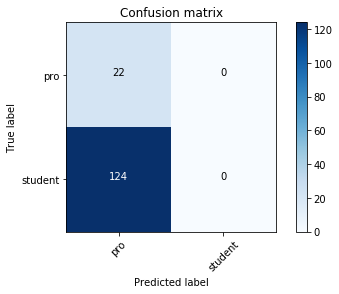

Test score for nmf method: 0.2619047619047619
Confusion matrix, without normalization
[[ 22   0]
 [124   0]]


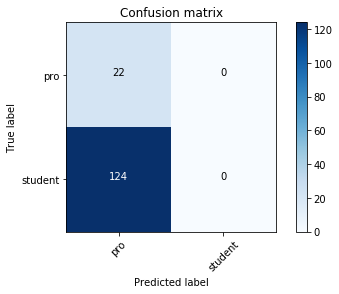

In [66]:
lin_svc_clf.score()

Test score for lsa method: 0.4905660377358491
Confusion matrix, without normalization
[[ 13   9]
 [ 18 106]]


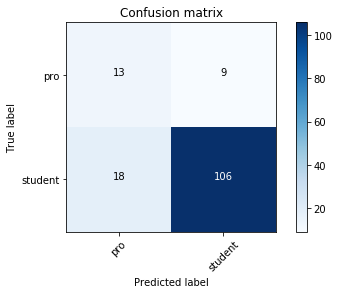

Test score for lda method: 0.0
Confusion matrix, without normalization
[[  0  22]
 [  0 124]]


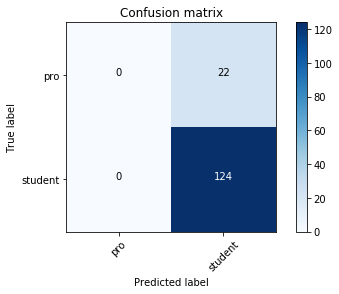

Test score for nmf method: 0.0
Confusion matrix, without normalization
[[  0  22]
 [  0 124]]


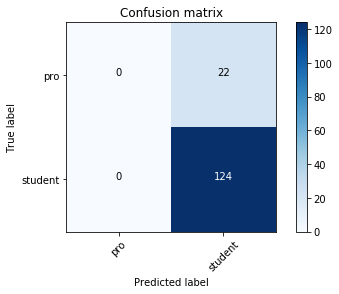

In [67]:
svc_clf.score()

Test score for lsa method: 0.3829787234042554
Confusion matrix, without normalization
[[  9  13]
 [ 16 108]]


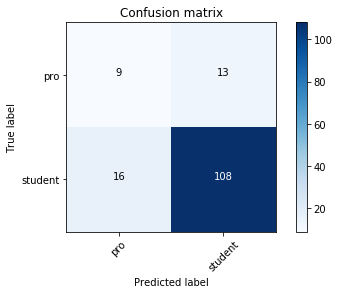

Test score for lda method: 0.5454545454545454
Confusion matrix, without normalization
[[ 12  10]
 [ 10 114]]


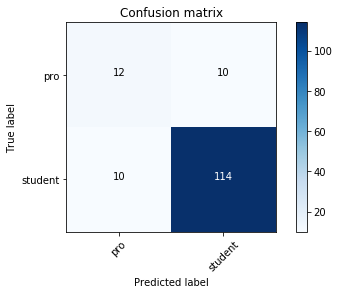

Test score for nmf method: 0.3684210526315789
Confusion matrix, without normalization
[[  7  15]
 [  9 115]]


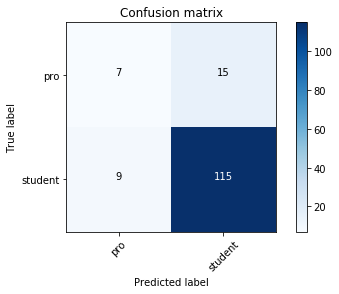

In [68]:
knn_clf.score()

Test score for lsa method: 0.3448275862068965
Confusion matrix, without normalization
[[  5  17]
 [  2 122]]


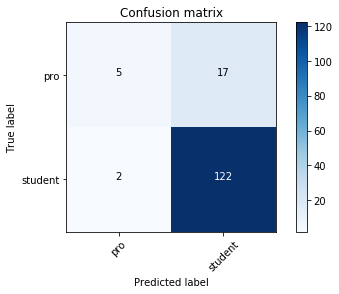

Test score for lda method: 0.34782608695652173
Confusion matrix, without normalization
[[  8  14]
 [ 16 108]]


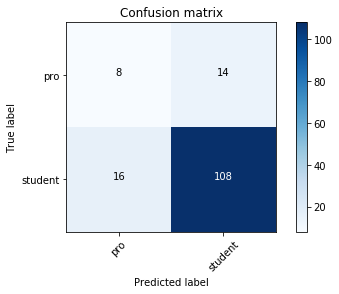

Test score for nmf method: 0.26666666666666666
Confusion matrix, without normalization
[[  4  18]
 [  4 120]]


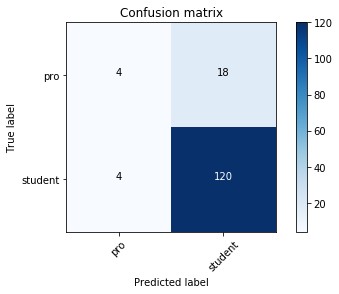

In [69]:
rand_for_clf.score()

# Conclusions
Self-explanatory

In [70]:
import winsound
frequency = np.random.randint(2000, 4000, 50)  # Set Frequency To 2500 Hertz
duration = 25  # Set Duration To 1000 ms == 1 second
for each in frequency:
    winsound.Beep(each, duration)

# Header